# Opioid Addiction Project
## Notebook 04: Modeling

This notebook executes the following tasks:

1. Model Preprocessing
2. Train a machine learning model
3. Score the model (measuring accuracy, precision, recall, F1, ROC)
4. Calibrate the model (and re-score, comparing uncalibrated vs. calibrated)
5. Save the model and calibration

Generating feature importance (Shapley values) was originally also part of this notebook, but the long  execution time of model training and calibration made it more efficient to include in a new notebook.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [36]:
#Import Required Libraries

#General libraries
import numpy as np
import pandas as pd
from sklearn.externals import joblib  #Used to save (pickle) models
import itertools

#Model Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #conda install -c conda-forge imbalanced-learn
import OpioidDataPrep as odp  #Custom functions for this project
from inspect import signature

#Feature selection
from sklearn.feature_selection import f_regression

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
#import xgboost #Tricky installation, see instructions (search for XGBoost)

#Model evaluation
from sklearn.metrics import (accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, 
                             classification_report, brier_score_loss, precision_score, precision_recall_curve
                             recall_score, f1_score, log_loss, make_scorer)
from sklearn.model_selection import (learning_curve, validation_curve)


#Calibration
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

#Visualization
import matplotlib.pyplot as plt

#Set initial parameter(s)
pd.set_option('display.max_rows', 100)
pd.options.display.max_columns = 20
dataDir = './data/'

#Notebook Custom Parameters
useSMOTE = True

print('Pandas Version', pd.__version__)
#print('XGBoost Version', xgboost.__version__)

Pandas Version 0.24.2


# 1. Load Data

This step loads the data from the file `features.pickle.zip`.

In [35]:
#Load Data
df = pd.read_csv(dataDir+'features.csv')
df

,Unnamed: 0,ADDPREV__GT1LTET2,ADDPREV__GT85LTET94,ADDPREV__GT94LTET97,ADDSCEV__GT1LTET2,ADDSCEV__GT2LTET94,ADDSCEV__GT94LTET97,ADDSCEV__GT97LTET98,ADDSCEV__GT98LTET99,AGE2,...,IRMJFY__GT50LTET100,IRMJFY__GT7LTET10,IRMJRC__GT1LTET2,IRMJRC__GT2LTET3,IRMJRC__GT3LTET9,IRSEX,MISUSE,TOBYR,TXEVRRCVD2,TXYRRECVD2
0,19,1,0,0,0,0,0,0,1,-1.188806,...,0,0,0,0,1,0,0,0,0,0
1,20,0,0,0,0,0,0,0,1,-0.730225,...,0,0,0,0,0,1,0,1,0,0
2,21,1,0,0,1,0,0,0,0,-0.607937,...,0,0,0,0,1,0,0,0,0,0
3,23,1,0,0,1,0,0,0,0,-0.944230,...,0,0,0,0,1,0,0,0,0,0
4,33,1,0,0,1,0,0,0,0,-0.730225,...,0,0,0,1,0,0,0,0,0,0
5,34,1,0,0,1,0,0,0,0,-0.883085,...,1,0,1,0,0,0,1,1,0,0
6,36,1,0,0,0,0,0,0,0,2.174124,...,0,0,0,0,1,1,0,0,0,0
7,46,1,0,0,1,0,0,0,0,-0.944230,...,0,0,0,0,0,1,1,0,0,0
8,50,1,0,0,1,0,0,0,0,0.462087,...,0,0,0,0,1,0,0,0,0,0
9,52,1,0,0,0,0,0,0,1,-1.188806,...,0,0,0,0,1,0,0,0,0,0


# 2. Model Preprocessing

In this section we'll ...

* Split the data into features (X) and the outcome variable, MISUSE (Y).
* Split the data into training, validation, and test sets.
* Oversample the data to address imbalance (optional, depending on modeling needs)

In [37]:
#We'll first sort the data by column name, necessary to prevent errors later
#Specfically, calibrating with the cv='prefit' option fails without this sort
df = odp.sortDFbyColName(df)
df

,ADDPREV__GT1LTET2,ADDPREV__GT85LTET94,ADDPREV__GT94LTET97,ADDSCEV__GT1LTET2,ADDSCEV__GT2LTET94,ADDSCEV__GT94LTET97,ADDSCEV__GT97LTET98,ADDSCEV__GT98LTET99,AGE2,BOOKED__GT1LTET2,...,IRMJFY__GT7LTET10,IRMJRC__GT1LTET2,IRMJRC__GT2LTET3,IRMJRC__GT3LTET9,IRSEX,MISUSE,TOBYR,TXEVRRCVD2,TXYRRECVD2,Unnamed: 0
0,1,0,0,0,0,0,0,1,-1.188806,1,...,0,0,0,1,0,0,0,0,0,19
1,0,0,0,0,0,0,0,1,-0.730225,1,...,0,0,0,0,1,0,1,0,0,20
2,1,0,0,1,0,0,0,0,-0.607937,1,...,0,0,0,1,0,0,0,0,0,21
3,1,0,0,1,0,0,0,0,-0.944230,1,...,0,0,0,1,0,0,0,0,0,23
4,1,0,0,1,0,0,0,0,-0.730225,0,...,0,0,1,0,0,0,0,0,0,33
5,1,0,0,1,0,0,0,0,-0.883085,1,...,0,1,0,0,0,1,1,0,0,34
6,1,0,0,0,0,0,0,0,2.174124,1,...,0,0,0,1,1,0,0,0,0,36
7,1,0,0,1,0,0,0,0,-0.944230,1,...,0,0,0,0,1,1,0,0,0,46
8,1,0,0,1,0,0,0,0,0.462087,0,...,0,0,0,1,0,0,0,0,0,50
9,1,0,0,0,0,0,0,1,-1.188806,1,...,0,0,0,1,0,0,0,0,0,52


## 2.1 Split Features (X) and Outcome (Y)

In [38]:
#Split X and Y
xCols = df.columns.difference(['MISUSE'])
dfX = df[xCols]
dfY = df.drop(xCols, axis=1)

#Inspect
print(dfX.head())
print(dfY.head(10))

   ADDPREV__GT1LTET2  ADDPREV__GT85LTET94  ADDPREV__GT94LTET97  \
0                  1                    0                    0   
1                  0                    0                    0   
2                  1                    0                    0   
3                  1                    0                    0   
4                  1                    0                    0   

   ADDSCEV__GT1LTET2  ADDSCEV__GT2LTET94  ADDSCEV__GT94LTET97  \
0                  0                   0                    0   
1                  0                   0                    0   
2                  1                   0                    0   
3                  1                   0                    0   
4                  1                   0                    0   

   ADDSCEV__GT97LTET98  ADDSCEV__GT98LTET99      AGE2  BOOKED__GT1LTET2  ...  \
0                    0                    1 -1.188806                 1  ...   
1                    0                    1 -0.73022

## 2.2 Split into Training, Validation, and Test

In [39]:
#Train, Val, Test splits
trainPct = 0.6
valPct = 0.25
testPct = 0.15

#Splitsville!
trainX, valtestX, trainY, valtestY = train_test_split(
    dfX, dfY, train_size=(trainPct), shuffle=True)
valX, testX, valY, testY = train_test_split(
     valtestX, valtestY, train_size=(valPct/(valPct+testPct)), shuffle=True)

#Check Shapes
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(32014, 97)
(32014, 1)
(13340, 97)
(13340, 1)
(8004, 97)
(8004, 1)


In [40]:
#SMOTE Oversampling
if useSMOTE:
    #From https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
    os = SMOTE(random_state=0)
    columns = trainX.columns
    osX, osY = os.fit_sample(trainX, trainY)
    osX = pd.DataFrame(data=osX,columns=columns)
    osY = pd.DataFrame(data=osY,columns=['MISUSE'])

    #Check the numbers of our data
    print("length of oversampled data is ",len(osX))
    print("Number MISUSE==0",len(osY[osY['MISUSE']==0]))
    print("Number MISUSE==1",len(osY[osY['MISUSE']==1]))
    print("Proportion of MISUSE==0 in oversampled data is ",len(osY[osY['MISUSE']==0])/len(osX))
    print("Proportion of MISUSE==1 in oversampled data is ",len(osY[osY['MISUSE']==1])/len(osX))

    #Check Shapes
    print(trainX.shape)
    print(trainY.shape)
    print(osX.shape)
    print(osY.shape)
    print(valX.shape)
    print(valY.shape)
    print(testX.shape)
    print(testY.shape)

    #Finally, set trainX and trainY to be osX and osY 
    #(allows the model to use trainX and trainY regardless of whether oversampling is selected)
    trainX, trainY = osX, osY

/Users/aditi_khullar/anaconda/envs/w241/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  53446
Number MISUSE==0 26723
Number MISUSE==1 26723
Proportion of MISUSE==0 in oversampled data is  0.5
Proportion of MISUSE==1 in oversampled data is  0.5
(32014, 97)
(32014, 1)
(53446, 97)
(53446, 1)
(13340, 97)
(13340, 1)
(8004, 97)
(8004, 1)


In [7]:
'''NO LONGER USING THIS, AND SAVING NUMPY FILES INSTEAD'''

#Save data files necessary for calculating feature importance, before conversion to numpy arrays
#valX.to_pickle(dataDir+'valX.pickle.zip')
#testX.to_pickle(dataDir+'testX.pickle.zip')
'''Note, the .to_pickle command INFERS zip compression based on the '.zip'
extension. Changing the extension will result in a HUGE file instead of a 
compressed file.
''';

## 2.3 Convert to Numpy

Next, we'll convert our data from pandas into numpy format, because several downstream components of the code / project don't work / work well with pandas, favoring the "numbers only" approach of numpy.  Specifically, this leads us to two tasks:

1. Convert data to numpy format.
2. Save column names for use later.

In [41]:
#Save column names to a pickle file
colNamesList = list(trainX.columns)

joblib.dump(colNamesList, dataDir+'colNamesList.zip')
    
'''To open in other files:
colNamesList = joblib.load(dataDir+'colNamesList.zip')
'''

#Convert dataframes to numpy arrays (do this AFTER saving column names)
trainX = trainX.values
trainY = trainY.values
valX = valX.values
valY = valY.values
testX = testX.values
testY = testY.values

#Save input data as numpy objects (for use in calculating feature importance, i.e., Shapley values)
np.save(arr=valX, file=dataDir+'valX.npy', allow_pickle=True)
np.save(arr=testX, file=dataDir+'testX.npy', allow_pickle=True)

# 3. Model Training

In this section we'll train a model.

Good article on validation loss: https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

## 3.1 Logistic Regression

Feature selection for regression - Using f_regressions to find the most important unvariate features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

In [74]:
fs = f_regression(trainX, trainY.ravel())
univariate_feature_importance = pd.DataFrame(list(zip(colNamesList, fs[0], fs[1])), columns = ["feature", "F-Value", "p-value"]).sort_values("p-value", ascending = True)
univariate_feature_importance

,feature,F-Value,p-value
67,IRHERRC__GT3LTET9,3001.370956,0.000000e+00
95,TXYRRECVD2,1799.737797,0.000000e+00
52,IRCIGRC__GT4LTET9,1974.611133,0.000000e+00
53,IRCOCRC__GT1LTET2,2606.042052,0.000000e+00
55,IRCOCRC__GT3LTET9,5737.917075,0.000000e+00
58,IRCRKRC__GT3LTET9,2025.835166,0.000000e+00
59,IRECSTMOREC__GT1LTET2,1570.827783,0.000000e+00
60,IRECSTMOREC__GT2LTET3,3840.308494,0.000000e+00
61,IRECSTMOREC__GT3LTET9,6812.625940,0.000000e+00
62,IRHALLUCREC__GT1LTET2,2452.151172,0.000000e+00


Full model - contains all features

In [83]:
import warnings
warnings.filterwarnings('ignore')
#Set and train a logistic regression model
modelLR = LogisticRegression()
modelLR.fit(trainX, trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Full model accuracy on Test data

In [79]:
testYPredicted = modelLR.predict(testX)
average_precision = average_precision_score(testY, testYPredicted)
average_precision

0.29649832658095354

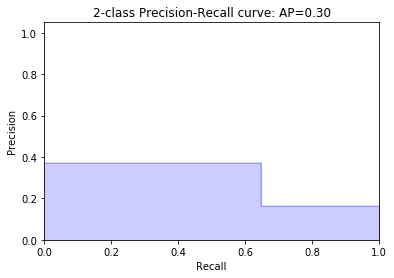

In [80]:
precision, recall, _ = precision_recall_curve(testY, y_score)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

In [81]:
# ToDo AK: train reduced model and check accuracy scores

[learning_curve] Training set sizes: [ 4275 13895 23515 33135 42756]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    4.7s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    7.4s finished
/Users/aditi_khullar/anaconda/envs/w241/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


RED = Training Data
GREEN = Cross Validation Data


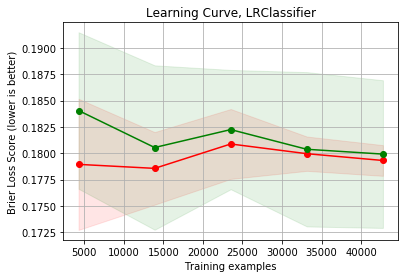

In [45]:
custScoreBrier = make_scorer(brier_score_loss, greater_is_better=True, needs_proba=True)

train_sizes, train_scores, test_scores = learning_curve(modelLR, trainX, trainY, n_jobs=-1, 
                                                        shuffle=True, verbose=2, cv=5, scoring=custScoreBrier)

#brier_score_loss

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve, LRClassifier")
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Brier Loss Score (lower is better)")
#plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
#plt.ylim(-.1,1.1)
print('RED = Training Data')
print('GREEN = Cross Validation Data')
plt.show()

In [43]:
param_range=[5,10,15,20,25]

train_scores, test_scores = validation_curve(modelLR, trainX, trainY, 'max_iter', cv=5, n_jobs=-1, verbose=2,
                                              param_range=param_range, scoring=custScoreBrier)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    5.7s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.2s finished


[[-0.24998467 -0.24999194 -0.24998771 -0.24998721 -0.24998281]
 [-0.24997824 -0.24998838 -0.24998574 -0.24998447 -0.24997532]
 [-0.2498803  -0.24993425 -0.24995555 -0.24994254 -0.24986114]
 [-0.24351073 -0.24636346 -0.24794839 -0.24716533 -0.24249182]
 [-0.18180946 -0.20841916 -0.22264435 -0.2148112  -0.19157321]]
[[-0.24999704 -0.24997053 -0.24998463 -0.24998656 -0.25000535]
 [-0.24999089 -0.24996654 -0.24998252 -0.24998389 -0.2499981 ]
 [-0.24989443 -0.24991221 -0.24995135 -0.2499433  -0.24988356]
 [-0.24366909 -0.24630004 -0.24787347 -0.24725291 -0.24249058]
 [-0.19556794 -0.20747373 -0.22139697 -0.21564273 -0.18816522]]
RED = Training Data
GREEN = Cross Validation Data


/Users/aditi_khullar/anaconda/envs/w241/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


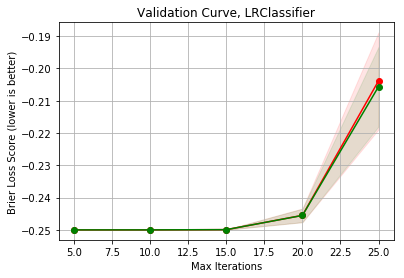

In [44]:
print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Validation Curve, LRClassifier")
plt.legend(loc="best")
plt.xlabel("Max Iterations")
plt.ylabel("Brier Loss Score (lower is better)")
#plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
#plt.ylim(-.1,1.1)
print('RED = Training Data')
print('GREEN = Cross Validation Data')
plt.show()

## 3.2 Extreme Gradient Boosting (XGBoost)

Train an XGBoost model.

In [13]:
#Custom Brier Scoring
def xg_Brier(y, t):
    t = t.get_label()
    return "Brier", brier_score_loss(t, y)

In [14]:
#Set and train the XGB model
modelXGB = xgboost.XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=90, n_jobs=-1,
                                booster='gbtree'
                                )
'''Notes:
    1. n_jobs=-1 maximizes CPU utilization
    2. Beware running high max_depth and n_estimators; the shapley estimator in notebook 5
    crashes with high values ("The kernel appears to have died" with no error messages).'''
eval_set = [(trainX, trainY), (testX, testY)]
modelXGB.fit(trainX, trainY, eval_metric=xg_Brier, verbose=True, eval_set=eval_set) # eval_metric=['logloss'],

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.181519	validation_1-error:0.181784	validation_0-Brier:0.227375	validation_1-Brier:0.231609
[1]	validation_0-error:0.178299	validation_1-error:0.176787	validation_0-Brier:0.209028	validation_1-Brier:0.216453
[2]	validation_0-error:0.173143	validation_1-error:0.177286	validation_0-Brier:0.193203	validation_1-Brier:0.203681
[3]	validation_0-error:0.166313	validation_1-error:0.177786	validation_0-Brier:0.180326	validation_1-Brier:0.193355
[4]	validation_0-error:0.159352	validation_1-error:0.17916	validation_0-Brier:0.168722	validation_1-Brier:0.184259
[5]	validation_0-error:0.15442	validation_1-error:0.177536	validation_0-Brier:0.158959	validation_1-Brier:0.176517
[6]	validation_0-error:0.151945	validation_1-error:0.175537	validation_0-Brier:0.150767	validation_1-Brier:0.170084
[7]	validation_0-error:0.145505	validation_1-error:0.172539	validation_0-Brier:0.143441	validation_1-Brier:0.16444
[8]	validation_0-error:0.145208	validation_1-error:0.170665	validation_0-Br

[71]	validation_0-error:0.0807	validation_1-error:0.149425	validation_0-Brier:0.063384	validation_1-Brier:0.117085
[72]	validation_0-error:0.080681	validation_1-error:0.149675	validation_0-Brier:0.063236	validation_1-Brier:0.117096
[73]	validation_0-error:0.080197	validation_1-error:0.1493	validation_0-Brier:0.062993	validation_1-Brier:0.117048
[74]	validation_0-error:0.079955	validation_1-error:0.149425	validation_0-Brier:0.062877	validation_1-Brier:0.11702
[75]	validation_0-error:0.079825	validation_1-error:0.149175	validation_0-Brier:0.062715	validation_1-Brier:0.116973
[76]	validation_0-error:0.079174	validation_1-error:0.149675	validation_0-Brier:0.062412	validation_1-Brier:0.116884
[77]	validation_0-error:0.07895	validation_1-error:0.149925	validation_0-Brier:0.062268	validation_1-Brier:0.116871
[78]	validation_0-error:0.078764	validation_1-error:0.14955	validation_0-Brier:0.062067	validation_1-Brier:0.116937
[79]	validation_0-error:0.078559	validation_1-error:0.149675	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=None, n_estimators=90,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

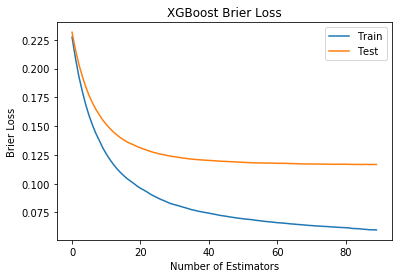

In [15]:
#Plot Log Loss Train vs. Test sets

results = modelXGB.evals_result()

epochs = len(results['validation_0']['Brier'])

x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['Brier'], label='Train')
ax.plot(x_axis, results['validation_1']['Brier'], label='Test')
ax.legend()
plt.xlabel('Number of Estimators')
plt.ylabel('Brier Loss')
plt.title('XGBoost Brier Loss')
plt.show()

In [16]:
#Build validation curve.  This cell takes ~1 min to run
runThis = False
if runThis:
    param_range=[25,50,75,100]
    
    train_scores, test_scores = validation_curve(modelXGB, trainX, trainY,
                                                 'n_estimators', cv=4, n_jobs=-1,
                                                 verbose=2, param_range=param_range,
                                                 scoring=custScoreBrier
                                                )

No handles with labels found to put in legend.


[[0.18867668 0.18793358 0.18796138 0.18857425 0.18840983]
 [0.18839891 0.18771166 0.18773574 0.18833936 0.18814625]
 [0.18839891 0.18771166 0.18773574 0.18833936 0.18814625]
 [0.18839891 0.18771166 0.18773574 0.18833936 0.18814625]
 [0.18839891 0.18771166 0.18773574 0.18833936 0.18814625]]
[[0.18825239 0.19059991 0.19063301 0.18790066 0.18853368]
 [0.18813297 0.19041439 0.19044274 0.18763204 0.18841212]
 [0.18813297 0.19041439 0.19044274 0.18763204 0.18841212]
 [0.18813297 0.19041439 0.19044274 0.18763204 0.18841212]
 [0.18813297 0.19041439 0.19044274 0.18763204 0.18841212]]
RED = Training Data
GREEN = Cross Validation Data


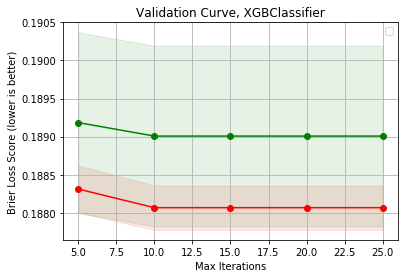

In [17]:
print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Validation Curve, XGBClassifier")
plt.legend(loc="best")
plt.xlabel("Max Iterations")
plt.ylabel("Brier Loss Score (lower is better)")
#plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
#plt.ylim(-.1,1.1)
print('RED = Training Data')
print('GREEN = Cross Validation Data')
plt.show()

## 3.3 Neural Network

In [18]:
#Set and train NN classifier
modelNN = MLPClassifier(hidden_layer_sizes=(5, 5, 5), max_iter=200)
modelNN.fit(trainX, trainY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

# 4. Model Evaluation (uncalibrated)

Here we'll develop the scoring routines to evaluate the uncalibrated model. We'll re-score in the calibration section to compare the uncalibrated vs. calibrated models.

## 4.1 Simple Counts

We'll begin by calculating simple counts of the model's predictions

In [19]:
#Count predictions. This gives a rough idea of the number of predictions
def predCounts(predsIn):
    '''Simple function to count our predictions
    NOTES:
    Return format: [[prediction1, count of prediction1]
                    [prediction2, count of prediction2]]

    The .T at the end simply transposes the array.

    What's nice about this function is it will also detect any counts
    that aren't 0 or 1, which can occasionally happen.
    '''
    return np.asarray(np.unique(predsIn, return_counts=True)).T

preds = modelXGB.predict(valX)
predCountFreq = predCounts(preds)
#print(predCountFreq) #Commenting out here because it's printed below

## 4.2 Confusion Matrix

In [20]:
#Helper Functions for Summarizing and Plotting Results
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Documented here as it is in the source.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized Confusion Matrix") #Commenting out since we plot this in a graph
    else:
        pass
        #print('Confusion Matrix') #Commenting out since we plot this in a graph

    #print(cm) #Commenting out since we plot this in a graph

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=20)
    plt.yticks(tick_marks, classes, size=20)

    fmt = '.1%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=20)
    plt.xlabel('Predicted label', size=20)

In [21]:
#Create text classification report
#print(classification_report(valY, preds)) #Commenting out here because it's printed below

# Compute confusion matrix
cnf_matrix = confusion_matrix(valY, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0, 1]

## 4.3 ROC Curve

In [22]:
#Function to plot ROC Curve
def pltROCCurve(fprIn, tprIn, trueY, predProbs):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fprIn, tprIn, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_true=trueY, y_score=predProbs))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate\n(how often predicts misuse when no misuse)')
    plt.ylabel('True Positive Rate\n(how often predicts misuse when actual misuse)')
    plt.show()

## 4.4 Calibraiton Curve

In [23]:
#Function to plot calibration curve
def pltCalCurve(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true=y_true, y_prob=y_prob, 
                                             n_bins=20, strategy='quantile', normalize=False)

    #Plot diag line
    plt.plot([0, 1], [0, 1], linestyle='--')

    #Plot calibration curves
    plt.plot(prob_pred, prob_true, marker='.')
    plt.xlabel('Predicted Probabilities')
    plt.ylabel('Actual Probabilities')
    plt.show()

## 4.5 Metrics Summary

This is just a convenient place to put all the metrics we've already calculated in one spot.

In [24]:
def resultsSummary(preds, predProbs, trueY):
    #Calculate Inputs
    cnf_matrix = confusion_matrix(trueY, preds)

    #Counts
    print('PREDICTION COUNTS:\n', predCounts(preds))

    #Accuracy
    print('\nACCURACY SCORES:')
    print('Model Accuracy: {:.2%}'.format(accuracy_score(y_true=trueY, y_pred=preds, normalize=True)))
    print('Model ROC AUC:  {:.2%}'.format(roc_auc_score(y_true=trueY, y_score=predProbs)))
    print('Brier Score Loss:  {:.3}'.format(brier_score_loss(y_true=trueY, y_prob=predProbs)))
    print('  (Brier Score Loss evaluates probability estimates, lower is better)')

    #Descriptive Stats
    print('\nDESCRIPTIVE STATS ON PREDICTED PROBABILITIES:')
    print(pd.DataFrame({'Descriptive Stats':predProbs}).describe())
    
    #Distribution of Predictions
    print('\nDISTRIBUTION OF PREDICTED PROBABILITIES:')
    plt.hist(predProbs, bins=50)
    plt.show()

    #Classificaiton Report
    print('\nCLASSIFICATION REPORT:')
    print(classification_report(trueY, preds))

    #Plot Confusion Matrix
    print('CONFUSION MATRIX:')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
    plt.show()

    #Print ROC Curve
    fpr, tpr, thresholds = roc_curve(trueY, predProbs)
    print('ROC CURVE:')
    pltROCCurve(fpr, tpr, trueY, predProbs)
    
    #Plot CalCurve
    pltCalCurve(trueY, predProbs)

## 4.6 Run Evaluations

### 4.6.1 Evaluate Logistic Regression Model

PREDICTION COUNTS:
 [[   0 9323]
 [   1 4017]]

ACCURACY SCORES:
Model Accuracy: 75.44%
Model ROC AUC:  78.84%
Brier Score Loss:  0.181
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.417671
std             0.219653
min             0.013353
25%             0.254038
50%             0.371879
75%             0.551323
max             0.996929

DISTRIBUTION OF PREDICTED PROBABILITIES:


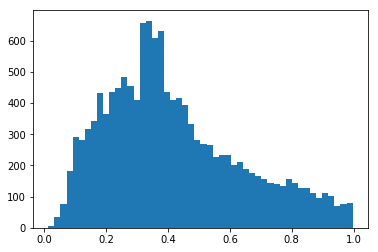


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     11115
           1       0.37      0.67      0.48      2225

    accuracy                           0.75     13340
   macro avg       0.64      0.72      0.66     13340
weighted avg       0.83      0.75      0.78     13340

CONFUSION MATRIX:


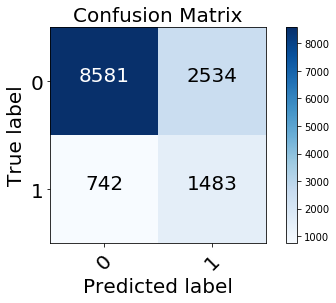

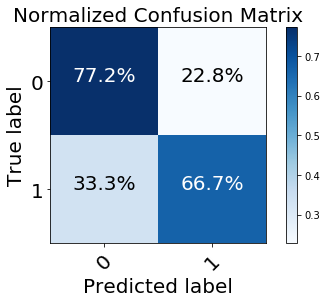

ROC CURVE:


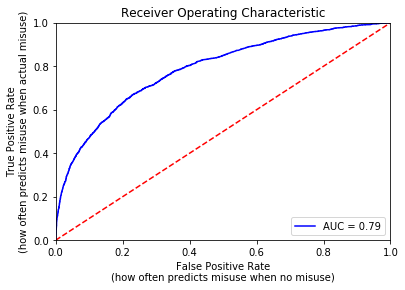

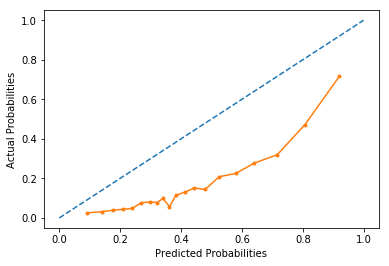

In [25]:
#Generate LR Predictions
predsLR = modelLR.predict(valX)
predProbsLR = modelLR.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelLRPredProbs.npy', arr=predProbsLR)

#Summarize
resultsSummary(predsLR, predProbsLR, valY)

### 4.6.2 Evaluate XGB Model

PREDICTION COUNTS:
 [[    0 12324]
 [    1  1016]]

ACCURACY SCORES:
Model Accuracy: 85.04%
Model ROC AUC:  75.72%
Brier Score Loss:  0.116
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.194271
std             0.178283
min             0.004022
25%             0.068894
50%             0.134402
75%             0.266439
max             0.967302

DISTRIBUTION OF PREDICTED PROBABILITIES:


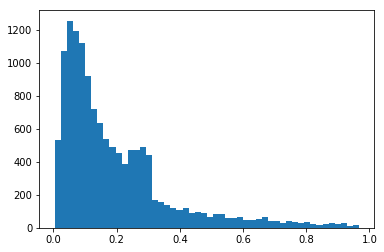


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     11115
           1       0.61      0.28      0.38      2225

    accuracy                           0.85     13340
   macro avg       0.74      0.62      0.65     13340
weighted avg       0.83      0.85      0.83     13340

CONFUSION MATRIX:


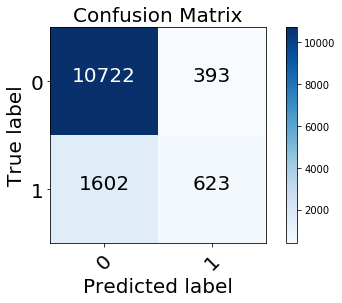

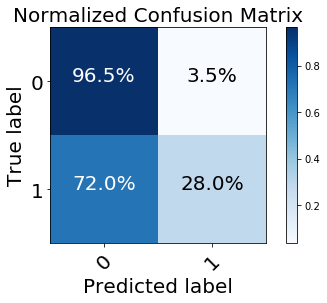

ROC CURVE:


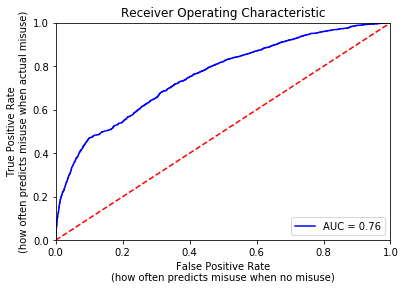

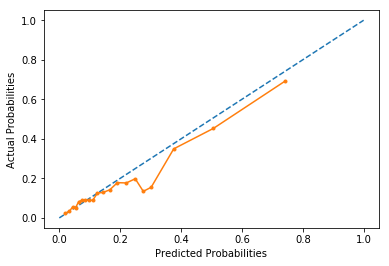

In [26]:
#Generate XGB Predictions
predsXGB = modelXGB.predict(valX)
predProbsXGB = modelXGB.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelXGBPredProbs.npy', arr=predProbsXGB)

#Summarize
resultsSummary(predsXGB, predProbsXGB, valY)

### 4.6.3 Evaluate Neural Network Model

PREDICTION COUNTS:
 [[    0 10149]
 [    1  3191]]

ACCURACY SCORES:
Model Accuracy: 77.78%
Model ROC AUC:  75.60%
Brier Score Loss:  0.169
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.367651
std             0.236901
min             0.000229
25%             0.185237
50%             0.324855
75%             0.491109
max             0.997381

DISTRIBUTION OF PREDICTED PROBABILITIES:


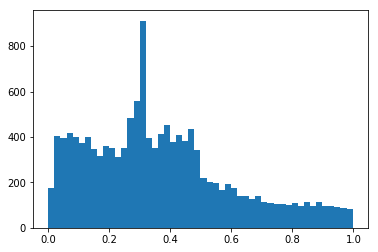


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     11115
           1       0.38      0.55      0.45      2225

    accuracy                           0.78     13340
   macro avg       0.64      0.69      0.66     13340
weighted avg       0.82      0.78      0.79     13340

CONFUSION MATRIX:


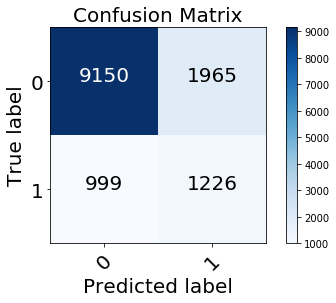

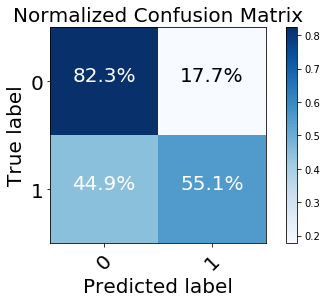

ROC CURVE:


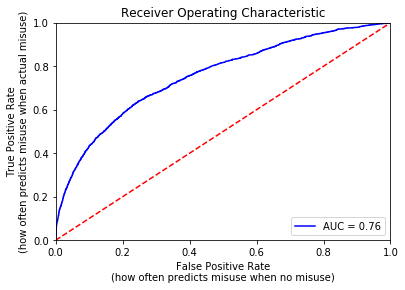

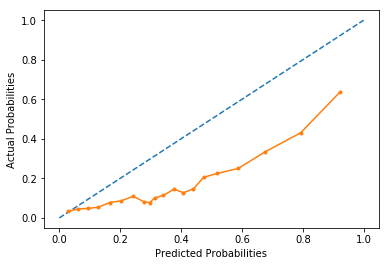

In [27]:
#Generate NN Predictions
predsNN = modelNN.predict(valX)
predProbsNN = modelNN.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelNNPredProbs.npy', arr=predProbsNN)

#Summarize
resultsSummary(predsNN, predProbsNN, valY)

# 5. Calibration

This section seeks to calibrate the model. That is, it makes the acutal probabilities from the model align with the actual probabilities.

Note, we calibrate on the validation data (valX, valY), and then evaluate with `resultsSummary` on the test data (testY)

In [28]:
#Now we'll calibrate the model
runCalibration = True

## 5.1 Calibrate Logistic Regression Model

In [29]:
if runCalibration:
    calibratorLR = CalibratedClassifierCV(modelLR, cv='prefit', method='isotonic')
    calibratorLR.fit(valX, valY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[   0 7516]
 [   1  488]]

ACCURACY SCORES:
Model Accuracy: 85.44%
Model ROC AUC:  76.75%
Brier Score Loss:  0.111
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.164787
std             0.170129
min             0.000000
25%             0.068966
50%             0.090909
75%             0.211340
max             1.000000

DISTRIBUTION OF PREDICTED PROBABILITIES:


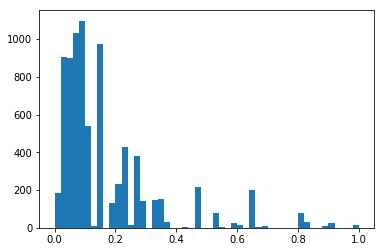


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6695
           1       0.65      0.24      0.35      1309

    accuracy                           0.85      8004
   macro avg       0.76      0.61      0.63      8004
weighted avg       0.83      0.85      0.83      8004

CONFUSION MATRIX:


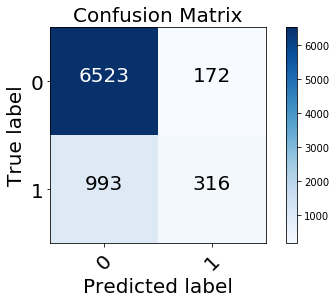

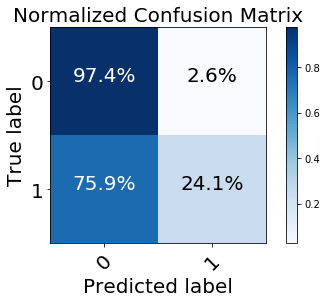

ROC CURVE:


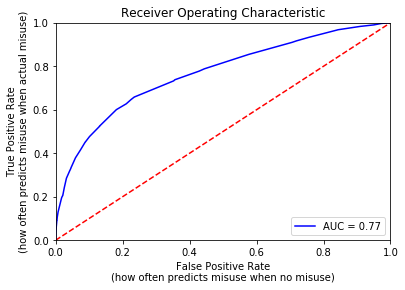

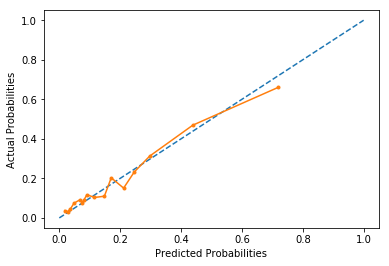

In [30]:
#Now recalculate predictions and print results
if runCalibration:
    predsLRCal = calibratorLR.predict(testX)
    predProbsLRCal = calibratorLR.predict_proba(testX)[:,1]
    resultsSummary(predsLRCal, predProbsLRCal, testY)
    
    np.save(file=dataDir+'modelLRCalPredProbs.npy', arr=predProbsLRCal)

## 5.2 Calibrate XGBoost Model

In [31]:
if runCalibration:
    calibratorXGB = CalibratedClassifierCV(modelXGB, method='sigmoid', cv='prefit')
    #cv='prefit' fails. Resorting the data didn't work.
    #Also, INCREASING TO cv=10 (FROM 3) GAVE A HUGE IMPROVEMENT.
    
    calibratorXGB.fit(valX, valY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[   0 7507]
 [   1  497]]

ACCURACY SCORES:
Model Accuracy: 85.08%
Model ROC AUC:  74.93%
Brier Score Loss:  0.115
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.166819
std             0.157860
min             0.055816
25%             0.076829
50%             0.105198
75%             0.186803
max             0.897666

DISTRIBUTION OF PREDICTED PROBABILITIES:


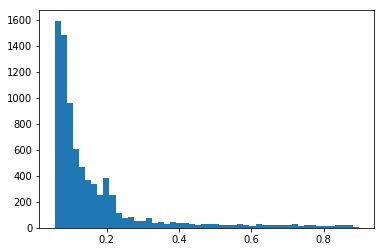


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6695
           1       0.62      0.23      0.34      1309

    accuracy                           0.85      8004
   macro avg       0.74      0.60      0.63      8004
weighted avg       0.83      0.85      0.82      8004

CONFUSION MATRIX:


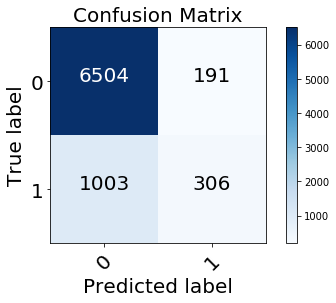

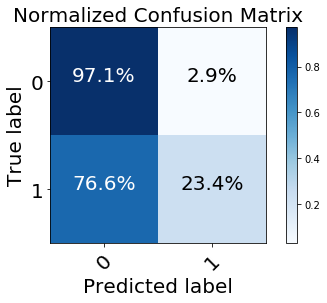

ROC CURVE:


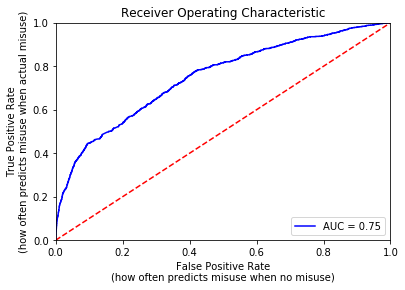

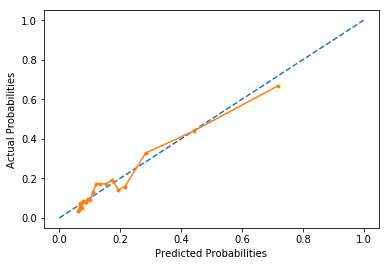

In [32]:
#Now recalculate predictions and print results
if runCalibration:
    predsXGBCal = calibratorXGB.predict(testX)
    predProbsXGBCal = calibratorXGB.predict_proba(testX)[:,1]
    resultsSummary(predsXGBCal, predProbsXGBCal, testY)
    
    np.save(file=dataDir+'modelXGBCalPredProbs.npy', arr=predProbsXGBCal)

## 5.3 Calibrate Neural Network Model

In [33]:
if runCalibration:
    calibratorNN = CalibratedClassifierCV(modelNN, method='isotonic', cv='prefit')    
    calibratorNN.fit(valX, valY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[   0 7587]
 [   1  417]]

ACCURACY SCORES:
Model Accuracy: 85.01%
Model ROC AUC:  73.65%
Brier Score Loss:  0.117
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count        8004.000000
mean            0.164225
std             0.149447
min             0.000000
25%             0.076687
50%             0.108159
75%             0.209581
max             1.000000

DISTRIBUTION OF PREDICTED PROBABILITIES:


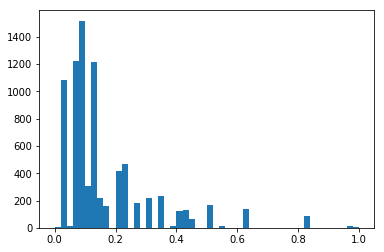


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6695
           1       0.63      0.20      0.30      1309

    accuracy                           0.85      8004
   macro avg       0.75      0.59      0.61      8004
weighted avg       0.82      0.85      0.82      8004

CONFUSION MATRIX:


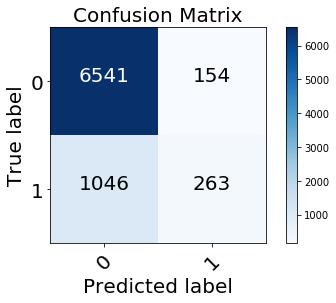

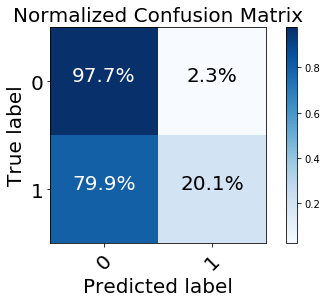

ROC CURVE:


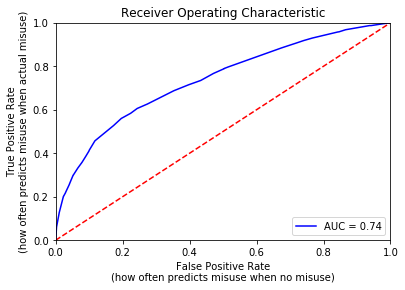

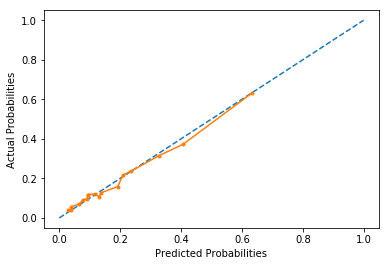

In [34]:
#Now recalculate predictions and print results
if runCalibration:
    predsNNCal = calibratorNN.predict(testX)
    predProbsNNCal = calibratorNN.predict_proba(testX)[:,1]
    resultsSummary(predsNNCal, predProbsNNCal, testY)
    
    np.save(file=dataDir+'modelNNCalPredProbs.npy', arr=predProbsNNCal)

# 6. Side By Side Model Comparisons

Here we'll look to compare results across all our models.

## 6.1 Side By Side Calibration Curves

Note these won't necessarily match the calibration curves ploted above because the ones in this section are calcualted on the test data, not the validation data. This strategy is correct because the calibrations themselves are generated from the validation data.

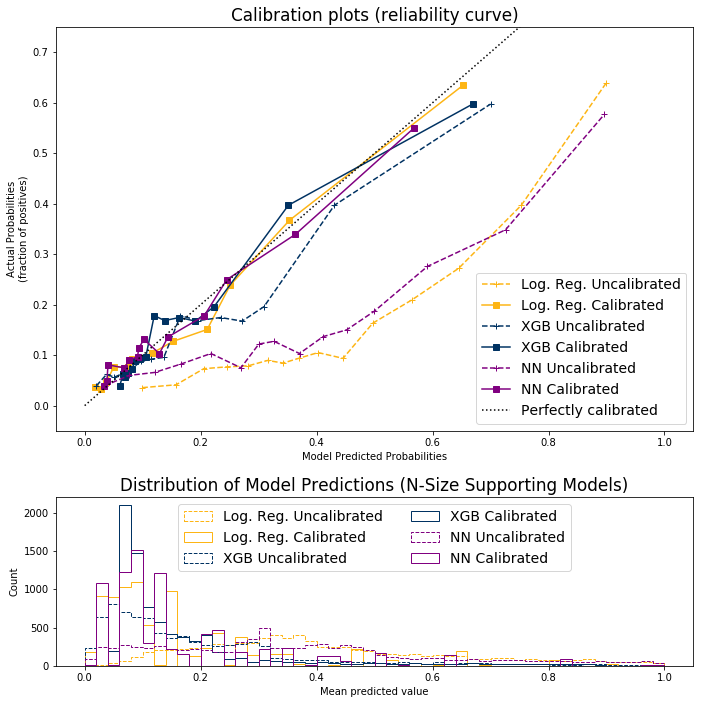

RESULTS TABLE, SORTED BY BRIER LOSS SCORE:


,Model,Brier Loss,Log Loss,ROC AUC,Precision,Recall,F1,Accuracy
0,Log. Reg. Calibrated,0.111240,0.373273,0.767493,0.647541,0.241406,0.351697,0.854448
0,XGB Calibrated,0.114671,0.379717,0.749323,0.615694,0.233766,0.338870,0.850825
0,XGB Uncalibrated,0.116723,0.385160,0.749323,0.582090,0.268144,0.367155,0.848826
0,NN Calibrated,0.116958,0.386372,0.736450,0.630695,0.200917,0.304751,0.850075
0,NN Uncalibrated,0.171335,0.523555,0.736791,0.375408,0.527120,0.438513,0.779235
0,Log. Reg. Uncalibrated,0.183202,0.552245,0.768065,0.359050,0.647059,0.461832,0.753373


In [35]:
#Initiate evaluation summary dataframe
dfEval = pd.DataFrame({'Model':[], 'Brier Loss':[], 'Log Loss':[], 'ROC AUC':[],
                       'Precision':[], 'Recall':[], 'F1':[], 'Accuracy':[]})

#Set up plots
fig = plt.figure(1, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
plt.rcParams.update({'font.size': 14})  #Set global font size

#Iterate through each model: print it scores and plot its calibration curve
for clf, name, lineColor, lineStyle in \
    [(modelLR, 'Log. Reg. Uncalibrated', '#FDB515', '+--'),
     (calibratorLR,'Log. Reg. Calibrated', '#FDB515', 's-'),
     (modelXGB, 'XGB Uncalibrated', '#003262', '+--'),     
     (calibratorXGB,'XGB Calibrated', '#003262', 's-'),
     (modelNN, 'NN Uncalibrated', 'purple', '+--'),     
     (calibratorNN,'NN Calibrated', 'purple', 's-'),
    ]:

    #Generate predictions
    preds = clf.predict(testX)
    predProbs = clf.predict_proba(testX)[:, 1]
    
    #Generate calibration curve data (strategy options are 'uniform' and 'quantile')
    prob_true, prob_pred = calibration_curve(y_true=testY, y_prob=predProbs, 
                                             n_bins=15, strategy='quantile', normalize=False)

    #Plot calibration curve
    ax1.plot(prob_pred, prob_true, lineStyle, color=lineColor, label=name)
    
    #Plot histogram of probabilities (support)
    ax2.hist(predProbs, range=(0, 1), bins=50, label=name, color=lineColor, 
             linestyle=lineStyle[1:], histtype="step", lw=1)

    #Populate evaulation dataframe    
    dictNewRow = {'Model':[name],
                  'Brier Loss':[brier_score_loss(y_true=testY, y_prob=predProbs)], 
                  'Log Loss':[log_loss(y_true=testY, y_pred=predProbs)], 
                  'ROC AUC':[roc_auc_score(y_true=testY, y_score=predProbs)], 
                  'Precision':[precision_score(y_true=testY, y_pred=preds)], 
                  'Recall':[recall_score(y_true=testY, y_pred=preds)], 
                  'F1':[f1_score(y_true=testY, y_pred=preds)], 
                  'Accuracy':[accuracy_score(y_true=testY, y_pred=preds)]
                 }
    dfEval = pd.concat([dfEval, pd.DataFrame(dictNewRow)])


#Stuff universal to all plots
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.set_xlabel("Model Predicted Probabilities")
ax1.set_ylabel("Actual Probabilities\n(fraction of positives)")
ax1.set_ylim([-0.05, 0.75])

ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
ax2.set_title('Distribution of Model Predictions (N-Size Supporting Models)')

zoomIn=False
if zoomIn:
    ax1.set_ylim([-0.00, 0.20])
    ax1.set_xlim([-0.00, 0.20])
    ax2.set_xlim([-0.00, 0.20])

plt.tight_layout()

plt.show() #Show plot
print('RESULTS TABLE, SORTED BY BRIER LOSS SCORE:')
dfEval.sort_values(by=['Brier Loss']) #Show eval

# 7. Save Model to Disk

Saving the model to disk at this point saves time, specifically so we don't have to re-train it every time we want to use it for predictions, feature importance, report generation, etc.

In [36]:
#Save model and any other necessary files
joblib.dump(modelLR, dataDir+'modelLR.model')
joblib.dump(modelXGB, dataDir+'modelXGB.model')
joblib.dump(modelNN, dataDir+'modelNN.model')

if runCalibration:
    joblib.dump(calibratorLR, dataDir+'calibLR.model')
    joblib.dump(calibratorXGB, dataDir+'calibXGB.model')
    joblib.dump(calibratorNN, dataDir+'calibNN.model')